# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

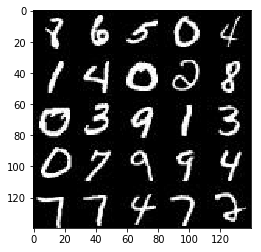

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

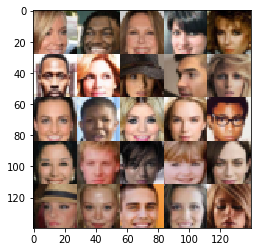

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0


/anaconda3/envs/floyd/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [26]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    learning_rate = tf.placeholder(tf.float32, name='learning_rate') 
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x(color channels) now
        
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    num_images, width, height, channels = data_shape
    real, z, lr = model_inputs(width, height, channels, z_dim)

    d_loss, g_loss = model_loss(real, z, channels)

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    show_every = 100
    print_every = 10
    losses = list()
    num_images = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z: batch_z, real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z: batch_z, real: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z, real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, num_images, z, channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0312... Generator Loss: 10.8731
Epoch 1/2... Discriminator Loss: 0.3460... Generator Loss: 2.9760
Epoch 1/2... Discriminator Loss: 0.7628... Generator Loss: 1.2177
Epoch 1/2... Discriminator Loss: 1.8592... Generator Loss: 0.3031
Epoch 1/2... Discriminator Loss: 1.8093... Generator Loss: 0.2717
Epoch 1/2... Discriminator Loss: 0.7448... Generator Loss: 1.4293
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.4534
Epoch 1/2... Discriminator Loss: 2.0151... Generator Loss: 0.2041
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 4.9317
Epoch 1/2... Discriminator Loss: 0.5286... Generator Loss: 3.1088


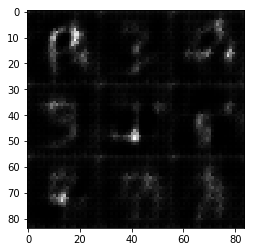

Epoch 1/2... Discriminator Loss: 0.1493... Generator Loss: 2.9450
Epoch 1/2... Discriminator Loss: 0.2614... Generator Loss: 3.5829
Epoch 1/2... Discriminator Loss: 0.0813... Generator Loss: 3.2044
Epoch 1/2... Discriminator Loss: 0.0561... Generator Loss: 3.3684
Epoch 1/2... Discriminator Loss: 0.0249... Generator Loss: 5.5502
Epoch 1/2... Discriminator Loss: 0.0833... Generator Loss: 3.7497
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.4563
Epoch 1/2... Discriminator Loss: 0.2082... Generator Loss: 2.9550
Epoch 1/2... Discriminator Loss: 1.9858... Generator Loss: 0.2890
Epoch 1/2... Discriminator Loss: 0.2087... Generator Loss: 2.2049


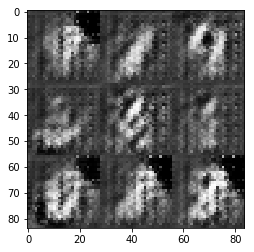

Epoch 1/2... Discriminator Loss: 0.4526... Generator Loss: 3.1047
Epoch 1/2... Discriminator Loss: 0.1626... Generator Loss: 2.4677
Epoch 1/2... Discriminator Loss: 0.1351... Generator Loss: 3.1792
Epoch 1/2... Discriminator Loss: 0.0736... Generator Loss: 4.4048
Epoch 1/2... Discriminator Loss: 0.0576... Generator Loss: 4.9886
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 1.2640
Epoch 1/2... Discriminator Loss: 2.9288... Generator Loss: 0.1074
Epoch 1/2... Discriminator Loss: 0.3902... Generator Loss: 2.1120
Epoch 1/2... Discriminator Loss: 0.1133... Generator Loss: 3.4720
Epoch 1/2... Discriminator Loss: 0.1264... Generator Loss: 2.8859


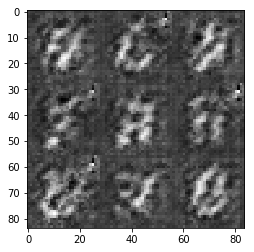

Epoch 1/2... Discriminator Loss: 0.1206... Generator Loss: 4.3502
Epoch 1/2... Discriminator Loss: 1.8514... Generator Loss: 0.3881
Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 2.1712
Epoch 1/2... Discriminator Loss: 0.6792... Generator Loss: 2.7253
Epoch 1/2... Discriminator Loss: 0.4165... Generator Loss: 1.4899
Epoch 1/2... Discriminator Loss: 1.7539... Generator Loss: 2.7193
Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 1.6112
Epoch 1/2... Discriminator Loss: 0.4558... Generator Loss: 1.6161
Epoch 1/2... Discriminator Loss: 0.1369... Generator Loss: 6.2057
Epoch 1/2... Discriminator Loss: 0.1884... Generator Loss: 2.5550


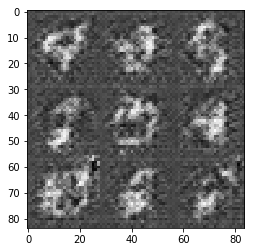

Epoch 1/2... Discriminator Loss: 0.1196... Generator Loss: 2.7328
Epoch 1/2... Discriminator Loss: 3.7038... Generator Loss: 9.2103
Epoch 1/2... Discriminator Loss: 1.6179... Generator Loss: 0.3203
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.3948
Epoch 1/2... Discriminator Loss: 0.4548... Generator Loss: 1.9937
Epoch 1/2... Discriminator Loss: 0.3803... Generator Loss: 2.1637
Epoch 2/2... Discriminator Loss: 0.2501... Generator Loss: 2.4005
Epoch 2/2... Discriminator Loss: 0.2192... Generator Loss: 3.1946
Epoch 2/2... Discriminator Loss: 0.2732... Generator Loss: 1.7852
Epoch 2/2... Discriminator Loss: 0.3162... Generator Loss: 2.0795


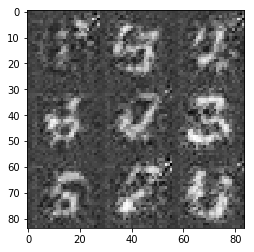

Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 0.8511
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 1.2128
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 2.0928
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 2.3980... Generator Loss: 0.1266
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.6008
Epoch 2/2... Discriminator Loss: 0.5124... Generator Loss: 1.1835
Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 1.4844
Epoch 2/2... Discriminator Loss: 0.4958... Generator Loss: 1.1915
Epoch 2/2... Discriminator Loss: 0.2591... Generator Loss: 3.2093


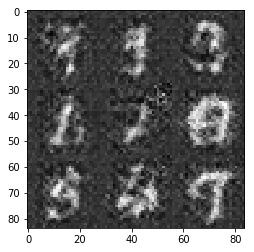

Epoch 2/2... Discriminator Loss: 0.1219... Generator Loss: 2.9374
Epoch 2/2... Discriminator Loss: 0.1037... Generator Loss: 4.0236
Epoch 2/2... Discriminator Loss: 0.1637... Generator Loss: 2.2011
Epoch 2/2... Discriminator Loss: 0.0684... Generator Loss: 3.9782
Epoch 2/2... Discriminator Loss: 0.1919... Generator Loss: 5.2819
Epoch 2/2... Discriminator Loss: 1.4949... Generator Loss: 3.6885
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 0.9281
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 0.8983
Epoch 2/2... Discriminator Loss: 0.4848... Generator Loss: 1.5357
Epoch 2/2... Discriminator Loss: 0.7594... Generator Loss: 1.9006


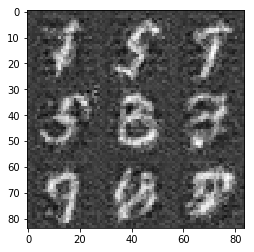

Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 0.4821... Generator Loss: 1.2966
Epoch 2/2... Discriminator Loss: 0.1803... Generator Loss: 2.7357
Epoch 2/2... Discriminator Loss: 0.1172... Generator Loss: 2.7657
Epoch 2/2... Discriminator Loss: 0.3334... Generator Loss: 1.5311
Epoch 2/2... Discriminator Loss: 0.0722... Generator Loss: 4.0649
Epoch 2/2... Discriminator Loss: 0.3182... Generator Loss: 1.5019
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 0.7356
Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 0.9431
Epoch 2/2... Discriminator Loss: 0.4074... Generator Loss: 1.3578


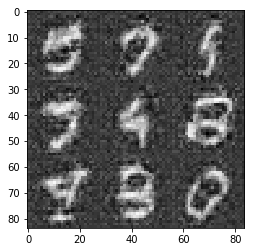

Epoch 2/2... Discriminator Loss: 0.1536... Generator Loss: 2.5765
Epoch 2/2... Discriminator Loss: 0.1595... Generator Loss: 2.4256
Epoch 2/2... Discriminator Loss: 0.4900... Generator Loss: 1.1854
Epoch 2/2... Discriminator Loss: 0.3283... Generator Loss: 1.4802
Epoch 2/2... Discriminator Loss: 0.0443... Generator Loss: 3.7895
Epoch 2/2... Discriminator Loss: 0.1668... Generator Loss: 2.1022
Epoch 2/2... Discriminator Loss: 0.0236... Generator Loss: 5.2465
Epoch 2/2... Discriminator Loss: 0.0415... Generator Loss: 4.6684
Epoch 2/2... Discriminator Loss: 0.0888... Generator Loss: 2.8235
Epoch 2/2... Discriminator Loss: 0.5961... Generator Loss: 1.9746


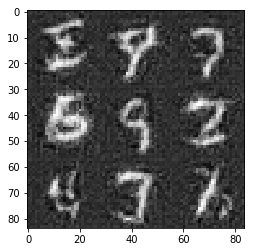

Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.4403
Epoch 2/2... Discriminator Loss: 1.7151... Generator Loss: 0.2593


In [36]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.7514... Generator Loss: 0.0017
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 1.3493
Epoch 1/1... Discriminator Loss: 2.8338... Generator Loss: 0.1836
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 5.3617
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 1.6989
Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 3.6653
Epoch 1/1... Discriminator Loss: 1.8842... Generator Loss: 0.2704
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 1.0930


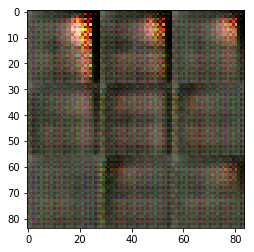

Epoch 1/1... Discriminator Loss: 0.2751... Generator Loss: 2.3465
Epoch 1/1... Discriminator Loss: 0.3084... Generator Loss: 1.4652
Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 1.6899
Epoch 1/1... Discriminator Loss: 0.2756... Generator Loss: 3.2409
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 3.7729
Epoch 1/1... Discriminator Loss: 5.9166... Generator Loss: 6.2286
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 0.7501... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 2.8363... Generator Loss: 5.0302


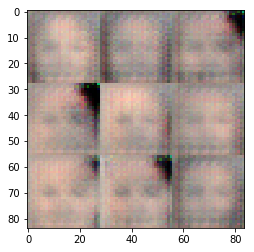

Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 2.1052
Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 3.5306
Epoch 1/1... Discriminator Loss: 0.6956... Generator Loss: 1.8165
Epoch 1/1... Discriminator Loss: 0.2481... Generator Loss: 2.1431
Epoch 1/1... Discriminator Loss: 0.2629... Generator Loss: 2.0279
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 1.6118
Epoch 1/1... Discriminator Loss: 0.2273... Generator Loss: 2.0233
Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 1.7901... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 1.3416


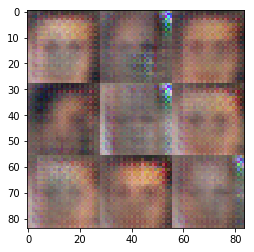

Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 1.9866
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 3.8302
Epoch 1/1... Discriminator Loss: 0.1329... Generator Loss: 3.2909
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 0.1478... Generator Loss: 2.9027
Epoch 1/1... Discriminator Loss: 0.1823... Generator Loss: 2.5387
Epoch 1/1... Discriminator Loss: 0.3236... Generator Loss: 1.8505
Epoch 1/1... Discriminator Loss: 0.1528... Generator Loss: 2.7373


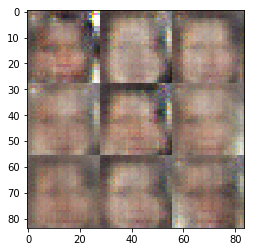

Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 6.3697
Epoch 1/1... Discriminator Loss: 0.2273... Generator Loss: 1.9227
Epoch 1/1... Discriminator Loss: 0.0409... Generator Loss: 5.2333
Epoch 1/1... Discriminator Loss: 0.2340... Generator Loss: 5.5902
Epoch 1/1... Discriminator Loss: 0.1008... Generator Loss: 4.6377
Epoch 1/1... Discriminator Loss: 2.9067... Generator Loss: 7.6461
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 3.3693
Epoch 1/1... Discriminator Loss: 2.2041... Generator Loss: 0.1474


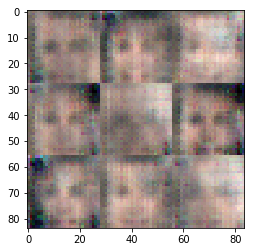

Epoch 1/1... Discriminator Loss: 0.4730... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 4.9974... Generator Loss: 5.1707
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 0.2391... Generator Loss: 2.6564
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 1.3046
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 3.2114... Generator Loss: 0.0556
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 3.8249


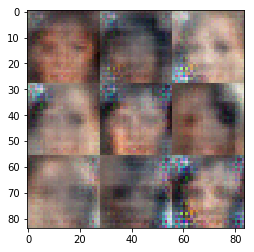

Epoch 1/1... Discriminator Loss: 1.7823... Generator Loss: 4.1164
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 2.7361
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 2.4109
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.3681
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 4.1682
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 1.5873... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8208


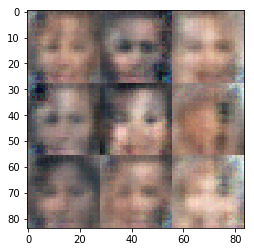

Epoch 1/1... Discriminator Loss: 1.7173... Generator Loss: 3.5014
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 0.1774... Generator Loss: 2.2533
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 0.2575... Generator Loss: 1.8968
Epoch 1/1... Discriminator Loss: 0.1083... Generator Loss: 4.2954
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 2.1148
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 0.3654


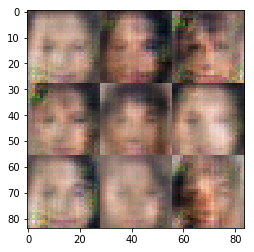

Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 1.6041
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 2.0059
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 1.6144
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 2.2587
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 0.9017


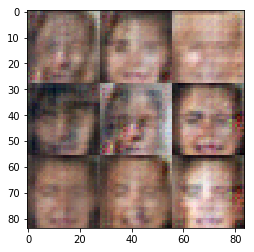

Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 2.1670
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.4543
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 2.1458... Generator Loss: 0.1979
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.8277
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 2.4227


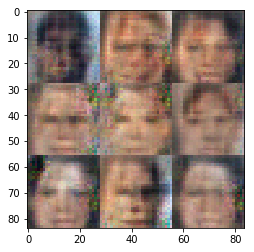

Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 0.0811... Generator Loss: 2.9956
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 5.6888
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.5331
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 3.8063
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 2.9463
Epoch 1/1... Discriminator Loss: 0.1139... Generator Loss: 5.1938
Epoch 1/1... Discriminator Loss: 6.2682... Generator Loss: 5.8585


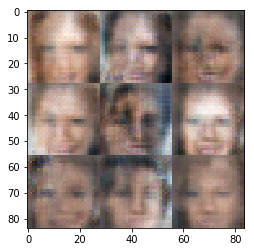

Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 5.0519
Epoch 1/1... Discriminator Loss: 0.3621... Generator Loss: 1.5057
Epoch 1/1... Discriminator Loss: 0.0571... Generator Loss: 4.3338
Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 5.0137
Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 6.3734
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 1.6165


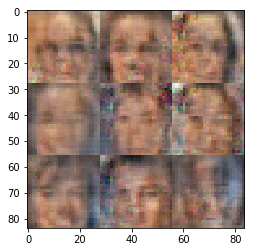

Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.3896
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.5965
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 1.7285
Epoch 1/1... Discriminator Loss: 0.5740... Generator Loss: 1.5219
Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 4.7029


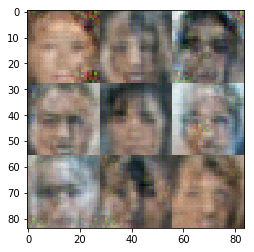

Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 2.9812
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 0.2243... Generator Loss: 2.1556
Epoch 1/1... Discriminator Loss: 0.2502... Generator Loss: 1.8500
Epoch 1/1... Discriminator Loss: 0.0653... Generator Loss: 3.8213
Epoch 1/1... Discriminator Loss: 0.1473... Generator Loss: 7.8923
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 1.0324


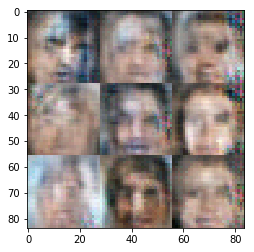

Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 1.7794
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 0.4970... Generator Loss: 1.1709


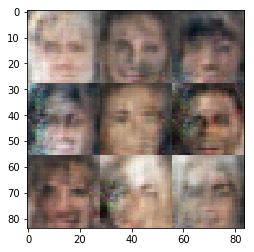

Epoch 1/1... Discriminator Loss: 0.3449... Generator Loss: 2.0966
Epoch 1/1... Discriminator Loss: 5.1978... Generator Loss: 5.6269
Epoch 1/1... Discriminator Loss: 0.2072... Generator Loss: 1.9330
Epoch 1/1... Discriminator Loss: 0.0694... Generator Loss: 5.2350
Epoch 1/1... Discriminator Loss: 0.0962... Generator Loss: 2.9610
Epoch 1/1... Discriminator Loss: 0.0823... Generator Loss: 2.9200


In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.